Preprocessing of the EV data from [1]; the dataset "Dataset 1_EV charging reports.csv" can be downloaded from [https://data.mendeley.com/datasets/jbks2rcwyj/1](https://data.mendeley.com/datasets/jbks2rcwyj/1)

From [1]: 'The CSV file “Dataset 1” describes 6,878 individual charging sessions, registered by 97 user IDs from December 2018 to January 2020. The charging reports include plug-in time, plug-out time and charged energy per charging session. Each charging session is connected to a user ID, charger ID and address. The charger IDs are either private or shared, since the charge points (CPs) are either located on the residents private parking spaces, or on shared parking areas available for all residents registered as users. ...'

[1] Sørensen, Å. L., Lindberg, K. B., Sartori, I., & Andresen, I. (2021). Residential electric vehicle charging datasets from apartment buildings. Data in Brief, 36, 107105.

In [1]:
# imports
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path

In [2]:
# settings
path_ev_orig = Path("input/original_ev_data/Dataset 1_EV charging reports.csv")  # original EV data from https://data.mendeley.com/datasets/jbks2rcwyj/1
path_output = Path("input")  # output of this script is input to the optimization
start_date = "2019-01-01"  # only consider charging sessions from this date onwards; format: YYYY-MM-DD (heat pump and household data starts on 01.01.2019)
end_date = "2020-01-01"  # only consider charging sessions until this date; format: YYYY-MM-DD (end_date is not included, EV data ends on 31.01.2020, local time)

tz_data = "Europe/Berlin"  # time zone of input data
tz_output = "UTC"  # time zone of output data

daterange = pd.date_range(start_date, end_date, freq="H", inclusive="left", tz=tz_output)  # hourly date range from start_date to end_date; time stamp indicates the start of a time interval
print(f"Daterange: {daterange[0]} - {daterange[-1]}")

Daterange: 2019-01-01 00:00:00+00:00 - 2019-12-31 23:00:00+00:00


In [3]:
# read in the data
ev_raw = pd.read_csv(path_ev_orig,sep=";")
ev_raw.head(2)

,session_ID,Garage_ID,User_ID,User_type,Shared_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,month_plugin,weekdays_plugin,Plugin_category,Duration_category
0,1,AdO3,AdO3-4,Private,NaN,21.12.2018 10:20,10,21.12.2018 10:23,10.0,"0,3","0,05",Dec,Friday,late morning (9-12),Less than 3 hours
1,2,AdO3,AdO3-4,Private,NaN,21.12.2018 10:24,10,21.12.2018 10:32,10.0,"0,87","0,136666667",Dec,Friday,late morning (9-12),Less than 3 hours


Data types and removal of data that is not relevant

In [4]:
ev = ev_raw.copy()

# drop specified columns
list_drop = ["month_plugin", "weekdays_plugin", "Plugin_category", "Duration_category", "Shared_ID"]
ev.drop(columns=list_drop, inplace=True)

# convert El_kWh and duration hours to float
ev["El_kWh"] = ev["El_kWh"].str.replace(",", ".")
ev.El_kWh = ev.El_kWh.astype(float)
ev["Duration_hours"] = ev["Duration_hours"].str.replace(",", ".")
ev.Duration_hours = ev.Duration_hours.astype(float)

# drop rows with no end plugout time
# from [1]: "If the plug-out time is too early, compared to energy charged and maximum 11 kW charging power available, the plug-out time is removed (set to NA), since this indicates that the value is incorrect (relevant for 34 charging sessions)."
ev.dropna(subset=["End_plugout"], inplace=True)

# only keep private charging sessions; then drop column "User_type"
ev = ev[ev["User_type"] != "Shared"]
assert list(ev["User_type"].unique()) == ["Private"], "Error: User_type should only contain 'Private'."
ev = ev.drop("User_type", axis=1)

# format plug-in and plug-out time; change time zone to UTC
# from [1]: "In the data provided with this article, Central European Time (CET) zone is used, which is GMT +1. Daylight saving time (DST) applies." (it's a Norwegian dataset)
for col in ["Start_plugin", "End_plugout"]:
    ev[col] = pd.to_datetime(ev[col], format="%d.%m.%Y %H:%M")
    ev[col] = ev[col].dt.tz_localize(tz_data).dt.tz_convert(tz_output)

# only consider charging sessions in defined time window
ev = ev[(ev["Start_plugin"].dt.date.isin(daterange.date)) & (ev["End_plugout"].dt.date.isin(daterange.date))]

# add new column with kWh/min if charging was distributed equally over entire duration
ev["kWh/min"] = ev["El_kWh"] / (ev["Duration_hours"] * 60)

# add new column with power in kW if charging was distributed equally over entire duration
ev["kW"] = ev["El_kWh"] / ev["Duration_hours"]

ev.head(2)

,session_ID,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,kWh/min,kW
13,14,AdO3,AdO3-4,2019-01-02 07:39:00+00:00,8,2019-01-03 08:11:00+00:00,9.0,28.11,24.533889,0.019096,1.145762
14,15,Bl2,Bl2-4,2019-01-02 18:59:00+00:00,19,2019-01-02 23:52:00+00:00,0.0,14.64,4.879722,0.050003,3.000171


Is each garage one charger or are there multiple chargers in one garage?

In [5]:
# example to show that there must be multiple chargers in one garage
# --> there are 3 different user IDs charging at the same time in garage "AdO1"
ev[(ev["Garage_ID"] == "AdO1") & (ev["Start_plugin"].dt.date == datetime.date(2019, 2, 28))]

# additionally, in Dataset 2, which "describes EV charging loads and non-charging idle capacity for each user and all EV charging sessions individually" [1], columns are "User_ID", "session_ID", ..., i.e., it does not contain the garage ID

,session_ID,Garage_ID,User_ID,Start_plugin,Start_plugin_hour,End_plugout,End_plugout_hour,El_kWh,Duration_hours,kWh/min,kW
250,251,AdO1,AdO1-2,2019-02-28 16:44:00+00:00,17,2019-03-01 09:01:00+00:00,10.0,5.61,16.286389,0.005741,0.344459
252,253,AdO1,AdO1-3,2019-02-28 18:02:00+00:00,19,2019-03-01 08:56:00+00:00,9.0,19.48,14.902222,0.021786,1.307188
254,255,AdO1,AdO1-1,2019-02-28 20:47:00+00:00,21,2019-03-01 05:27:00+00:00,6.0,15.39,8.653056,0.029643,1.778562


Create a dataframe for hourly charging processes

In [6]:
# get all unique user IDs
unique_users_ = sorted(ev["User_ID"].unique())
print("Number of unique users: ", len(unique_users_))

Number of unique users:  52


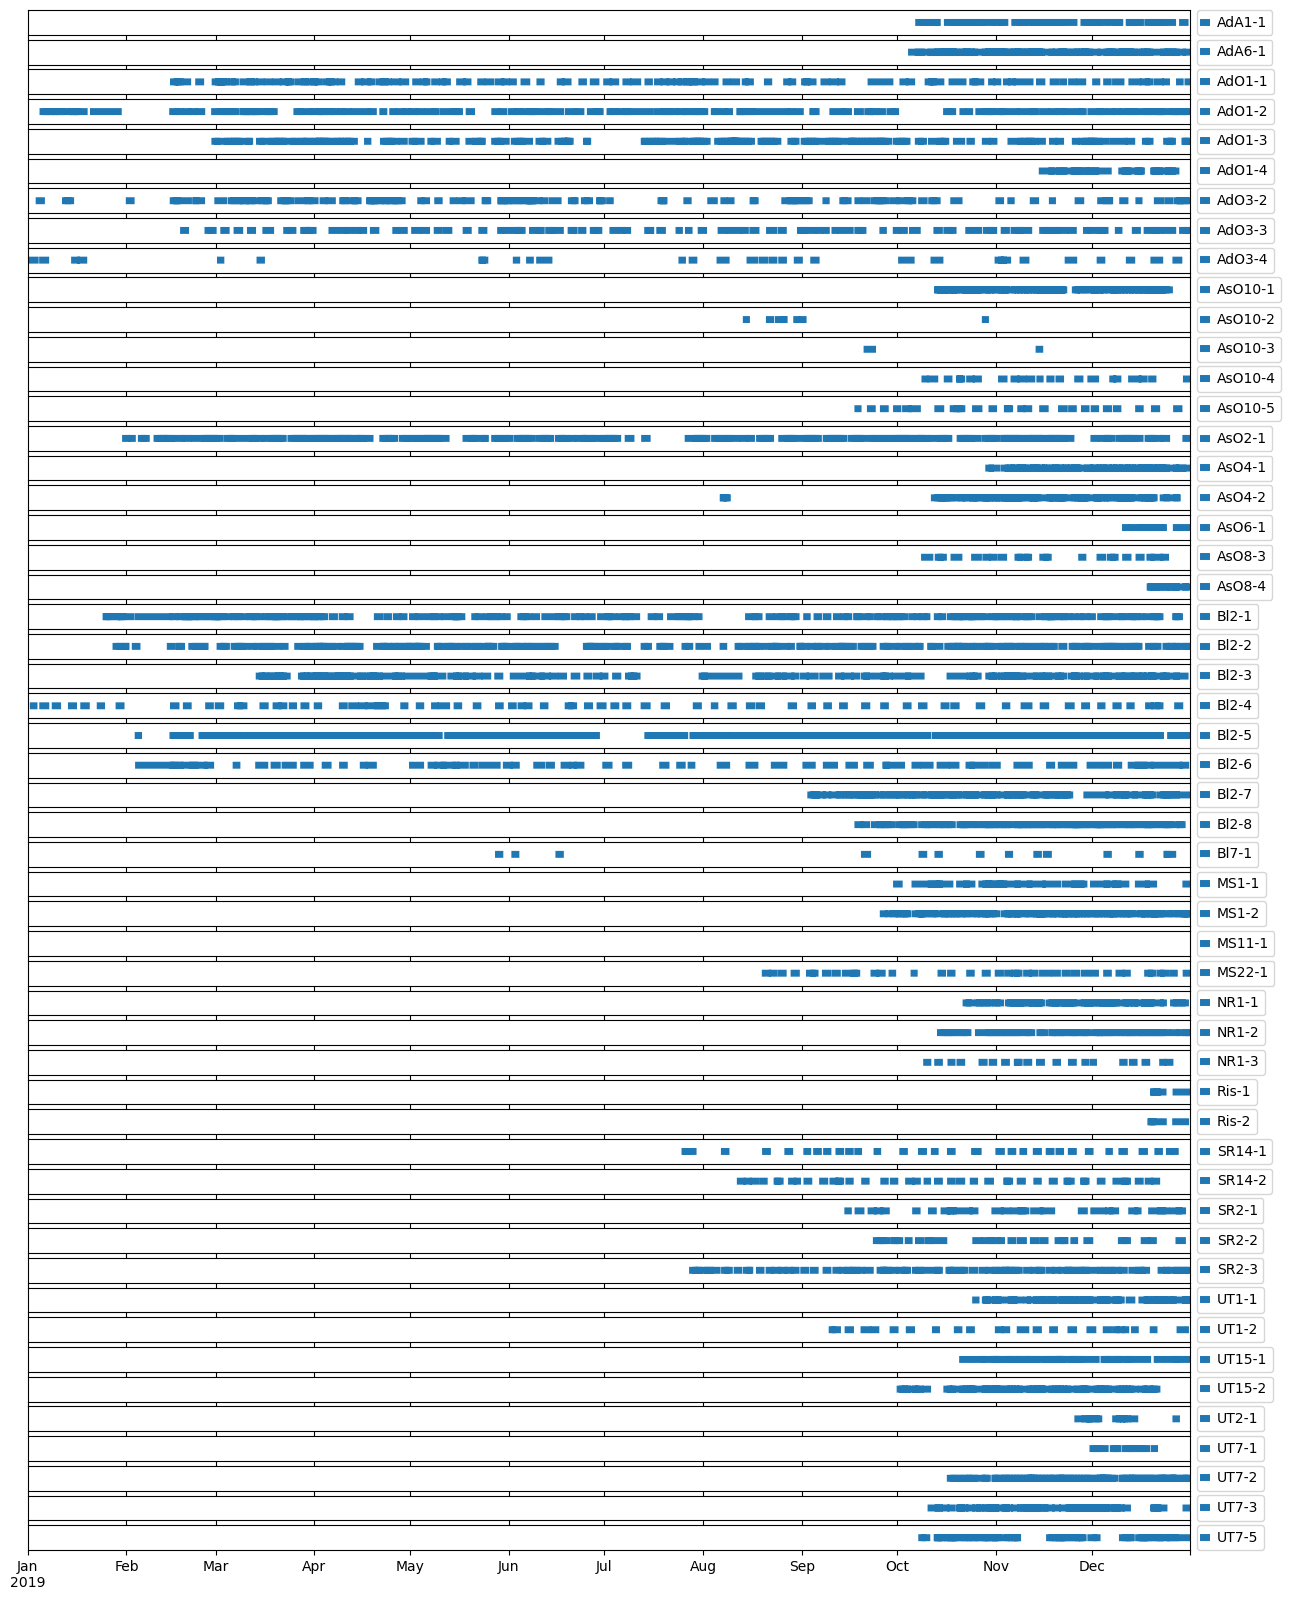

In [12]:
# plot the charging processes over time for each user
fig, axs = plt.subplots(figsize=(15, 20), nrows=len(unique_users_), sharex=True, sharey=True)
for i, u in enumerate(unique_users_):
    ts = pd.Series(np.empty(len(daterange)), index=daterange)
    ts[:] = np.nan
    df_u = ev[ev["User_ID"] == u]
    for _, c in df_u.iterrows():
        s = c["Start_plugin"].replace(minute=0)
        e = c["End_plugout"].replace(minute=0)
        ts.loc[s:e] = 1
    ts.plot(ax=axs[i], linewidth=5, label=u)
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5), handlelength=0.2)
    axs[i].set_ylim(0.9, 1.1)
    axs[i].set_yticks([])  # remove y-ticks
    axs[i].set_xticks([], minor=True)  # remove minor x-ticks

many users only joined/switched to a private charging station towards the end of the time period &rarr; only consider users that have at least one charging process in the first <n_weeks> weeks of date range

In [8]:
n_weeks = 12
unique_users = []
for u in unique_users_:
    df_u = ev[ev["User_ID"] == u]
    if df_u["Start_plugin"].dt.date.isin(np.unique(daterange.date)[:n_weeks * 7]).any():
        unique_users.append(u)
print("Number of unique users left: ", len(unique_users))
print("Corresponding user IDs: ", unique_users)

Number of unique users left:  13
Corresponding user IDs:  ['AdO1-1', 'AdO1-2', 'AdO1-3', 'AdO3-2', 'AdO3-3', 'AdO3-4', 'AsO2-1', 'Bl2-1', 'Bl2-2', 'Bl2-3', 'Bl2-4', 'Bl2-5', 'Bl2-6']


In [13]:
# initialize dataframe with zeros
col_per_user = ["kWh",  # kWh charged in this hour
                "share_of_hour",  # how long is the EV plugged-in in this hour; e.g.: 0.5 means 30 minutes
                "start",  # indicates if a charging process starts in this hour; 1 if yes, 0 if no
                "hours_until_end",  # how many hours does the charging process last (in the same row where "start" is 1); e.g., if charging process starts at 10:10 and ends at 12:30, then "hours_until_end" is 2
                ]
columns = pd.MultiIndex.from_product([unique_users, col_per_user])
ev_hourly = pd.DataFrame(np.zeros((len(daterange),len(unique_users) * len(col_per_user))) , index=daterange, columns=columns)

# iterate over all user IDs
list_same_hour = []
list_overlapping = []
for u in unique_users:
    idx_last_start = None # start HOUR of last charging process
    ts_last_end = None  # end TIMESTAMP of last charging process

    # get all charging processes of one user
    df_u = ev[ev["User_ID"] == u]

    # iterate over all charging processes of one user
    for _, c in df_u.iterrows():
        c = c.to_dict()

        # check for overlapping charging processes for the same user ID; example: AdO1 on 17.01.2020
        # --> only the first charging process is considered
        if ts_last_end is not None and c["Start_plugin"] < ts_last_end:
            list_overlapping.append((u, c["Start_plugin"]))
            continue
        else:
            # define start and end date and hour
            s = c["Start_plugin"].replace(minute=0)
            e = c["End_plugout"].replace(minute=0)

            # iterate over all indexes of the dataframe ev_hourly
            for idx in ev_hourly.index:
                # if idx >= s (plug-in hour) and <= e (plug-out hour), then the EV is charging in that time interval
                if s <= idx <= e:
                    # if charging process starts in this hour, set "start" to 1 and compute "hours_until_end"
                    # note: there can be edge cases where
                    # 1) two charging processes start in the same hour (first one very short)
                    # 2) one charging process ends and another one starts in the same hour
                    # in these cases, the 2 charging processes are considered as one; value "hours_until_end" is the sum of the two charging processes
                    if idx == s:
                        hours_until_end = (e - s).days * 24 + (e - s).seconds / 3600
                        if idx_last_start is None or idx > idx_last_start + datetime.timedelta(hours=ev_hourly.loc[idx_last_start, (u, "hours_until_end")]): # no edge case
                            ev_hourly.loc[idx, (u, "start")] = 1
                            ev_hourly.loc[idx, (u, "hours_until_end")] = hours_until_end
                            idx_last_start = idx
                        else:  # edge case --> consider the two charging processes as one
                            ev_hourly.loc[idx_last_start, (u, "hours_until_end")] += hours_until_end
                            list_same_hour.append((idx_last_start, u))

                    # compute the number of minutes for which the EV is plugged-in in the current hour
                    if idx == s and s != e:  # charging process starts in this hour, but ends in another hour
                        minutes = 60 - c["Start_plugin"].minute
                    elif idx == e and e == s:  # charging process starts and ends in this hour
                        minutes = c["End_plugout"].minute - c["Start_plugin"].minute
                    elif idx == e and s != e:  # charging process ends in this hour, but has started in another hour
                        minutes = c["End_plugout"].minute
                    else:  # charging process starts and ends in another hour
                        minutes = 60

                    # add the charged energy and share of hour to the dataframe
                    # note: values are added to the current value in the dataframe as there can be multiple charging processes in the same hour
                    ev_hourly.loc[idx, (u, "kWh")] = ev_hourly.loc[idx, (u, "kWh")] + minutes * c["kWh/min"]
                    ev_hourly.loc[idx, (u, "share_of_hour")] = ev_hourly.loc[idx, (u, "share_of_hour")] + minutes / 60

            # update last end time
            ts_last_end = c["End_plugout"]

# print("List of indices to check for edge cases: ", list_same_hour)
print("List of overlapping charging processes: ", list_overlapping)
# filter for rows where the first user is charging and show the first 5 rows
ev_hourly[ev_hourly.loc[:, pd.IndexSlice[unique_users[0], "kWh"]] > 0].head(5)

List of overlapping charging processes:  []


AdO1-1                                      \
                                kWh share_of_hour start hours_until_end   
2019-02-15 18:00:00+00:00  1.676010      0.933333   1.0            11.0   
2019-02-15 19:00:00+00:00  1.795724      1.000000   0.0             0.0   
2019-02-15 20:00:00+00:00  1.795724      1.000000   0.0             0.0   
2019-02-15 21:00:00+00:00  1.795724      1.000000   0.0             0.0   
2019-02-15 22:00:00+00:00  1.795724      1.000000   0.0             0.0   

                             AdO1-2                                      \
                                kWh share_of_hour start hours_until_end   
2019-02-15 18:00:00+00:00  0.186346           1.0   0.0             0.0   
2019-02-15 19:00:00+00:00  0.186346           1.0   0.0             0.0   
2019-02-15 20:00:00+00:00  0.186346           1.0   0.0             0.0   
2019-02-15 21:00:00+00:00  0.186346           1.0   0.0             0.0   
2019-02-15 22:00:00+00:00  0.186346           1.0   0.0             0.0   

                          AdO1-3                ... Bl2-4                  \
                             kWh share_of_hour  ... start hours_until_end   
2019-02-15 18:00:00+00:00    0.0           0.0  ...   1.0            19.0   
2019-02-15 19:00:00+00:00    0.0           0.0  ...   0.0             0.0   
2019-02-15 20:00:00+00:00    0.0           0.0  ...   0.0             0.0   
2019-02-15 21:00:00+00:00    0.0           0.0  ...   0.0             0.0   
2019-02-15 22:00:00+00:00    0.0           0.0  ...   0.0             0.0   

                              Bl2-5                                      \
                                kWh share_of_hour start hours_until_end   
2019-02-15 18:00:00+00:00  0.445989           1.0   0.0             0.0   
2019-02-15 19:00:00+00:00  0.445989           1.0   0.0             0.0   
2019-02-15 20:00:00+00:00  0.445989           1.0   0.0             0.0   
2019-02-15 21:00:00+00:00  0.445989           1.0   0.0             0.0   
2019-02-15 22:00:00+00:00  0.445989           1.0   0.0             0.0   

                              Bl2-6                                      
                                kWh share_of_hour start hours_until_end  
2019-02-15 18:00:00+00:00  0.525822           1.0   0.0             0.0  
2019-02-15 19:00:00+00:00  0.525822           1.0   0.0             0.0  
2019-02-15 20:00:00+00:00  0.525822           1.0   0.0             0.0  
2019-02-15 21:00:00+00:00  0.525822           1.0   0.0             0.0  
2019-02-15 22:00:00+00:00  0.525822           1.0   0.0             0.0  

[5 rows x 52 columns]

Convert kWh to Wh

In [14]:
ev_hourly.loc[:, pd.IndexSlice[:, "kWh"]] = ev_hourly.loc[:, pd.IndexSlice[:, "kWh"]] * 1000
ev_hourly.rename(columns={"kWh": "Wh"}, level=1, inplace=True)
ev_hourly[ev_hourly.loc[:, pd.IndexSlice[unique_users[0], "Wh"]] > 0].head(5)

AdO1-1                                      \
                                    Wh share_of_hour start hours_until_end   
2019-02-15 18:00:00+00:00  1676.009501      0.933333   1.0            11.0   
2019-02-15 19:00:00+00:00  1795.724465      1.000000   0.0             0.0   
2019-02-15 20:00:00+00:00  1795.724465      1.000000   0.0             0.0   
2019-02-15 21:00:00+00:00  1795.724465      1.000000   0.0             0.0   
2019-02-15 22:00:00+00:00  1795.724465      1.000000   0.0             0.0   

                              AdO1-2                                      \
                                  Wh share_of_hour start hours_until_end   
2019-02-15 18:00:00+00:00  186.34636           1.0   0.0             0.0   
2019-02-15 19:00:00+00:00  186.34636           1.0   0.0             0.0   
2019-02-15 20:00:00+00:00  186.34636           1.0   0.0             0.0   
2019-02-15 21:00:00+00:00  186.34636           1.0   0.0             0.0   
2019-02-15 22:00:00+00:00  186.34636           1.0   0.0             0.0   

                          AdO1-3                ... Bl2-4                  \
                              Wh share_of_hour  ... start hours_until_end   
2019-02-15 18:00:00+00:00    0.0           0.0  ...   1.0            19.0   
2019-02-15 19:00:00+00:00    0.0           0.0  ...   0.0             0.0   
2019-02-15 20:00:00+00:00    0.0           0.0  ...   0.0             0.0   
2019-02-15 21:00:00+00:00    0.0           0.0  ...   0.0             0.0   
2019-02-15 22:00:00+00:00    0.0           0.0  ...   0.0             0.0   

                               Bl2-5                                      \
                                  Wh share_of_hour start hours_until_end   
2019-02-15 18:00:00+00:00  445.98874           1.0   0.0             0.0   
2019-02-15 19:00:00+00:00  445.98874           1.0   0.0             0.0   
2019-02-15 20:00:00+00:00  445.98874           1.0   0.0             0.0   
2019-02-15 21:00:00+00:00  445.98874           1.0   0.0             0.0   
2019-02-15 22:00:00+00:00  445.98874           1.0   0.0             0.0   

                                Bl2-6                                      
                                   Wh share_of_hour start hours_until_end  
2019-02-15 18:00:00+00:00  525.821865           1.0   0.0             0.0  
2019-02-15 19:00:00+00:00  525.821865           1.0   0.0             0.0  
2019-02-15 20:00:00+00:00  525.821865           1.0   0.0             0.0  
2019-02-15 21:00:00+00:00  525.821865           1.0   0.0             0.0  
2019-02-15 22:00:00+00:00  525.821865           1.0   0.0             0.0  

[5 rows x 52 columns]

Save the edited data as csv

In [15]:
ev_hourly.to_csv(path_output / "Hourly_EV_Charging.csv", sep=";")

How to filter in multi-index

In [16]:
# one specific user
ev_hourly.loc[:, (unique_users[0], "Wh")].head(5)

2019-01-01 00:00:00+00:00    0.0
2019-01-01 01:00:00+00:00    0.0
2019-01-01 02:00:00+00:00    0.0
2019-01-01 03:00:00+00:00    0.0
2019-01-01 04:00:00+00:00    0.0
Freq: H, Name: (AdO1-1, Wh), dtype: float64

In [17]:
# all users, but only Wh
ev_hourly.loc[:, pd.IndexSlice[:, "Wh"]].droplevel(axis=1, level=1).head(2)

,AdO1-1,AdO1-2,AdO1-3,AdO3-2,AdO3-3,AdO3-4,AsO2-1,Bl2-1,Bl2-2,Bl2-3,Bl2-4,Bl2-5,Bl2-6
2019-01-01 00:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-01-01 01:00:00+00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Maximum charging for each user

In [18]:
for u in unique_users:
    print(f"Max. charging power for user {u} in W: {ev_hourly.loc[:, (u, 'Wh')].max()}")

Max. charging power for user AdO1-1 in W: 3649.962919723489
Max. charging power for user AdO1-2 in W: 3064.1048671040708
Max. charging power for user AdO1-3 in W: 7215.364413291578
Max. charging power for user AdO3-2 in W: 3754.403423076748
Max. charging power for user AdO3-3 in W: 3680.7663223062573
Max. charging power for user AdO3-4 in W: 6685.362516871225
Max. charging power for user AsO2-1 in W: 3573.788459585214
Max. charging power for user Bl2-1 in W: 3608.1151377281735
Max. charging power for user Bl2-2 in W: 3671.564389396174
Max. charging power for user Bl2-3 in W: 5978.260869565217
Max. charging power for user Bl2-4 in W: 6710.458081244597
Max. charging power for user Bl2-5 in W: 3662.1880991051466
Max. charging power for user Bl2-6 in W: 3579.170684115075
